In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

# Degrees of freedom for simple regression

In [2]:
pd.set_option('display.precision', 4)
pd.set_option('display.float_format', '{:.4f}'.format)  # Avoid scientific notation

In [8]:
num = 10000
X = np.random.normal(0, 1, num)
Y = 3 * X + np.random.normal(0, 1, num)
df = sm.add_constant(pd.DataFrame({"X": X}))
results = sm.OLS(Y, df).fit()
results.bse

const   0.0101
X       0.0102
dtype: float64

In [9]:
X_bse_estimate = np.sqrt(np.var(Y - results.predict(df), ddof = 2) / (np.var(X, ddof = 0) * num))
X_bse_estimate

0.010150996322456793

In [56]:
num = 50
X = np.random.normal(0, 1, num)
Y = 3 * X + np.random.normal(0, 1, num)
df = sm.add_constant(pd.DataFrame({"X": X}))
results = sm.OLS(Y, df).fit()
results.bse

const   0.1430
X       0.1510
dtype: float64

In [57]:
X_bse_estimate = np.sqrt(np.var(Y - results.predict(df), ddof = 2) / np.var(X, ddof = 0) / num)
X_bse_estimate

0.15098924867216384

$$\sqrt{\frac{\sigma^2}{\text{Var}(X) \cdot n}}$$

# Degrees of freedom for multiple linear regression

In [30]:
num = 200
Z = np.random.normal(0, 1, num)
X = Z + np.random.normal(0, 1, num)
Y = 3 * X - 1.5 * Z + np.random.normal(0, 1, num)
df = sm.add_constant(pd.DataFrame({"X": X, "Z": Z}))
results = sm.OLS(Y, df).fit()
results.bse

const   0.0741
X       0.0750
Z       0.1090
dtype: float64

In [21]:
np.linalg.inv(df.values.T @ df.values)[1, 1]

0.12040022852849955

In [22]:
X_bse_estimate = np.sqrt(np.var(Y - results.predict(df), ddof = 3) * (np.linalg.inv(df.values.T @ df.values)[1, 1]))
X_bse_estimate

0.18361550169416804

In [31]:
def simulate():
    params_list = list()
    for _ in range(1000):
        num = 200
        Z = np.random.normal(0, 1, num)
        X = Z + np.random.normal(0, 1, num)
        Y = 3 * X - 1.5 * Z + np.random.normal(0, 1, num)
        df = sm.add_constant(pd.DataFrame({"X": X, "Z": Z}))
        results = sm.OLS(Y, df).fit()
        params_list.append(results.params.X)
    return params_list

np.array(simulate()).std()

0.07084764490169325

In [42]:
# https://stats.stackexchange.com/questions/27916/standard-errors-for-multiple-regression-coefficients

num = 100
Z = np.random.normal(0, 1, num)
X = Z + np.random.normal(0, 1, num)
Y = 3 * X - 1.5 * Z + np.random.normal(0, 1, num)
df = sm.add_constant(pd.DataFrame({"X": X, "Z": Z}))
results = sm.OLS(Y, df).fit()
results.bse

const   0.0908
X       0.0897
Z       0.1349
dtype: float64

In [98]:
# https://numpy.org/doc/stable/reference/generated/numpy.var
# “Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, where N represents the number of elements.
# https://www.6sigma.us/six-sigma-in-focus/df-statistics-degrees-of-freedom-in-statistics/
# "For linear regression models, the degree of freedom for error is the sample size minus the number of 
# parameters estimated in the model, including the intercept."

X_design = df.values
resid_var = np.var(Y - results.predict(df), ddof = X_design.shape[1])
cov_matrix = resid_var * np.linalg.inv(X_design.T @ X_design)
print("statsmodels SE for X:", results.bse["X"])
print("manual SE for X:", np.sqrt(cov_matrix[1, 1]))

statsmodels SE for X: 0.46068023353324183
manual SE for X: 0.4606802335332418


In [102]:
def simulate(numruns = 10000):
    paramlist = list()
    for _ in range(numruns):
        num = 100
        Z = np.random.normal(0, 1, num)
        X = Z + np.random.normal(0, 1, num)
        Y = 3 * X - 1.5 * Z + np.random.normal(0, 1, num)
        df = sm.add_constant(pd.DataFrame({"X": X, "Z": Z}))
        results = sm.OLS(Y, df).fit()
        paramlist.append(results.params.X)
    return paramlist

np.array(simulate()).std()

0.10299441921575296

In [ ]:
resid_var = np.var(results.resid, ddof=results.df_model + 1)

# Get design matrix (X and Z with constant)
X_design = df.values

# Variance-covariance matrix of beta estimates
cov_matrix = resid_var * np.linalg.inv(X_design.T @ X_design)

# Standard error of coefficient on X (index 1 since index 0 is constant)
np.sqrt(cov_matrix[1, 1])

# P-hacking with polynomial models

In [55]:
poly_degree = 3
base = [(True, False)] * poly_degree
products = list(itertools.product(*base))

In [34]:
num = 100
def f(X):
    return X + X**2
X = np.random.normal(0, 1, num)
Y = f(X) + np.random.normal(0, 1, num)

X_train, X_test, y_train, y_test = train_test_split(X, Y)

df_train = sm.add_constant(pd.DataFrame({"X": X_train}))
df_test = sm.add_constant(pd.DataFrame({"X": X_test}))
df_train_X_2 = sm.add_constant(pd.DataFrame({"X": X_train, "X_2": X_train**2}))
df_test_X_2 = sm.add_constant(pd.DataFrame({"X": X_test, "X_2": X_test**2}))

results = sm.OLS(y_train, df_train).fit()
root_mean_squared_error(y_test, results.predict(df_test))

1.1230378126449898

In [36]:
results_X_2 = sm.OLS(y_train, df_train_X_2).fit()
root_mean_squared_error(y_test, results_X_2.predict(df_test_X_2)) # The error in lecture was results_X_2 was written as results

0.7780101585639523

In [68]:
num = 100
def f(X):
    return X + X**2
X = np.random.normal(0, 1, num)
Y = f(X) + np.random.normal(0, 1, num)

X_train, X_test, y_train, y_test = train_test_split(X, Y)

for p in products:   
#results = sm.OLS(y_train, sm.add_constant(X_train)).fit()
#err_false = root_mean_squared_error(y_test, results.predict(sm.add_constant(X_test)))
    if not any(p):
        continue
    d_train = dict()
    d_test = dict()
    for n, b in enumerate(p):
        if b:
            d_train[f"X_{n+1}"] = X_train**(n + 1)
            d_test[f"X_{n+1}"] = X_test**(n + 1)
    df_train = sm.add_constant(pd.DataFrame(d_train))
    df_test = sm.add_constant(pd.DataFrame(d_test))
    results = sm.OLS(y_train, df_train).fit()
    err_true = root_mean_squared_error(y_test, results.predict(df_test))
    print(err_true, p)

1.1769585542329022 (True, True, True)
1.1388159700147147 (True, True, False)
1.3577427885358742 (True, False, True)
1.3979661632733913 (True, False, False)
1.1771628967227494 (False, True, True)
1.4570144251087405 (False, True, False)
1.5203039295161107 (False, False, True)


In [131]:
def f(X):
    return X + X**2
num = 100
num_poly_terms = 10
X = np.linspace(0.1, 10, num)
Y = f(X) + np.random.normal(0, 2, num)
X_train, X_test, y_train, y_test = train_test_split(X, Y)
df_train = pd.DataFrame({"X": X_train, "Y": y_train})
df_test = pd.DataFrame({"X": X_test, "Y": y_test})
truefalse = [(True, False)] * num_poly_terms
prod = list(itertools.product(*truefalse))
best_prod = list()
best_error = np.inf
for p in prod:
    dfcopy_train = df_train.copy()
    dfcopy_test = df_test.copy()
    for n, b in enumerate(p):
        if b:
            dfcopy_train[f"X_{n+2}"] = dfcopy_train.X**(n+2)
            dfcopy_test[f"X_{n+2}"] = dfcopy_test.X**(n+2)
    results = sm.OLS(dfcopy_train.Y, sm.add_constant(dfcopy_train.drop(columns = ["Y"]))).fit()
    new_error = root_mean_squared_error(dfcopy_test.Y, results.predict(sm.add_constant(dfcopy_test.drop(columns = ["Y"]))))
    if new_error < best_error:
        best_prod = p
        best_error = new_error
        print(dfcopy_train.columns)

print(best_prod, best_error)

Index(['X', 'Y', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9',
       'X_10', 'X_11'],
      dtype='object')
Index(['X', 'Y', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9',
       'X_10'],
      dtype='object')
Index(['X', 'Y', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9'], dtype='object')
Index(['X', 'Y', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_10'], dtype='object')
Index(['X', 'Y', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_11'], dtype='object')
Index(['X', 'Y', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_9', 'X_10'], dtype='object')
Index(['X', 'Y', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_9', 'X_11'], dtype='object')
Index(['X', 'Y', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_10', 'X_11'], dtype='object')
Index(['X', 'Y', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7'], dtype='object')
Index(['X', 'Y', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_8'], dtype='object')
Index(['X', 'Y', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_9'], dtype='objec

const    7.4707
X       -4.8375
X_6      0.2895
X_7     -0.2637
X_8      0.1038
X_9     -0.0227
X_10     0.0030
X_11    -0.0002
X_12     0.0000
X_13    -0.0000
dtype: float64
0.2946276582434112
const   0.0000
X       0.0002
X_6     0.0407
X_7     0.0516
X_8     0.0624
X_9     0.0729
X_10    0.0831
X_11    0.0929
X_12    0.1024
X_13    0.1115
dtype: float64


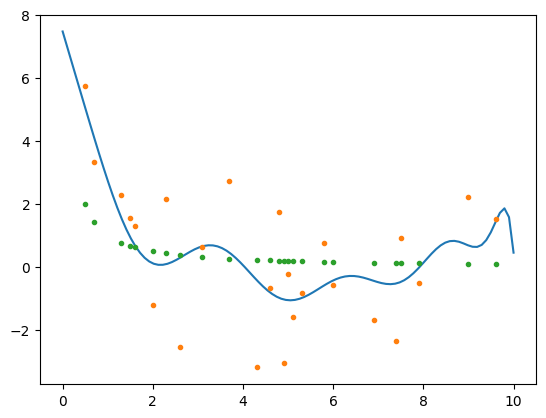

In [67]:
def f(X):
    return 1 / X
np.random.seed(0)
num = 100
num_poly_terms = 12
X = np.linspace(0.1, 10, num)
epsilon = np.random.normal(0, 2, num)
Y = f(X) + epsilon
X_train, X_test, y_train, y_test = train_test_split(X, Y)
df_train = pd.DataFrame({"X": X_train, "Y": y_train})
df_test = pd.DataFrame({"X": X_test, "Y": y_test})
truefalse = [(True, False)] * num_poly_terms
prod = itertools.product(*truefalse)
tvalue_list = list()
best_ra = 0
best_metric = np.inf
best_Y = None
for p in prod:
    dfcopy_train = df_train.copy()
    dfcopy_test = df_test.copy()
    for n, b in enumerate(p):
        if b:
            dfcopy_train[f"X_{n+2}"] = X_train**(n+2)
            dfcopy_test[f"X_{n+2}"] = X_test**(n+2)
    results = sm.OLS(y_train, sm.add_constant(dfcopy_train.drop(columns = "Y"))).fit()
    tvalue_list.append(results.tvalues.X)
    metric = root_mean_squared_error(y_test, results.predict(sm.add_constant(dfcopy_test.drop(columns = "Y"))))
    if metric < best_metric:
        best_metric = metric
        best_poly = dfcopy
        best_result = results
        best_Y = np.zeros(100)
        for param in results.params.keys():
            if param == "const":
                best_Y += results.params.const
            elif param == "X":
                best_Y += results.params.X * np.linspace(0, 10, 100)
            else:
                exponent = int(param[2:])
                best_Y += results.params[param] * np.linspace(0, 10, 100)**exponent
    #print(results.rsquared_adj)

#plt.hist(tvalue_list)
print(best_result.params)
plt.plot(np.linspace(0, 10, 100), best_Y)
plt.plot(df_test["X"], df_test["Y"], ".")
plt.plot(df_test["X"], f(df_test["X"]), ".")
print(best_result.rsquared_adj)
print(best_result.pvalues)

# Basic version

In [25]:
num = 10000
np.random.seed(0)
X = np.random.normal(0, 5, num)
Z = np.random.normal(0, 5, num)
epsilon = np.random.normal(0, 5, num)
Y = 2 * X - Z + epsilon
df = pd.DataFrame({"X": X, "Y": Y, "Z": Z})
results = sm.OLS(Y, sm.add_constant(df[["X", "Z"]])).fit()
results.bse

const    0.049880
X        0.010100
Z        0.010044
dtype: float64

In [19]:
results.params.X

2.002229223529292

In [7]:
def coef_std_basic():
    param_list = list()
    np.random.seed(0)
    for n in range(100):
        num = 10000
        X = np.random.normal(0, 5, num)
        Z = np.random.normal(0, 5, num)
        epsilon = np.random.normal(0, 5, num)
        Y = 2 * X - Z + epsilon
        df = pd.DataFrame({"X": X, "Y": Y, "Z": Z})
        results = sm.OLS(Y, sm.add_constant(df[["X", "Z"]])).fit()
        param_list.append(results.params.X)
    return param_list

print(np.std(coef_std_basic()))

0.011273152493143175


# Mean of error term is not zero

In [24]:
num = 10000
np.random.seed(0)
X = np.random.normal(0, 5, num)
Z = np.random.normal(0, 5, num)
epsilon = np.random.normal(3, 5, num)
Y = 2 * X - Z + epsilon
df = pd.DataFrame({"X": X, "Y": Y, "Z": Z})
results = sm.OLS(Y, sm.add_constant(df[["X", "Z"]])).fit()
results.bse

const    0.049880
X        0.010100
Z        0.010044
dtype: float64

In [22]:
results.params.X

2.0022292235292927

In [12]:
def coef_std_nonzero_mean():
    param_list = list()
    np.random.seed(0)
    for n in range(100):
        num = 10000
        X = np.random.normal(0, 5, num)
        Z = np.random.normal(0, 5, num)
        epsilon = np.random.normal(2, 5, num)
        Y = 2 * X - Z + epsilon
        df = pd.DataFrame({"X": X, "Y": Y, "Z": Z})
        results = sm.OLS(Y, sm.add_constant(df[["X", "Z"]])).fit()
        param_list.append(results.params.X)
    return param_list

print(np.std(coef_std_nonzero_mean()))

0.011273152493143231


# Error term is correlated with X

In [26]:
num = 10000
X = np.random.normal(0, 5, num)
Z = np.random.normal(0, 5, num)
epsilon = X + np.random.normal(0, 5, num)
Y = 2 * X - Z + epsilon
df = pd.DataFrame({"X": X, "Y": Y, "Z": Z, "epsilon": epsilon})
results = sm.OLS(Y, sm.add_constant(df[["X", "Z"]])).fit()
results.bse

const    0.049967
X        0.009908
Z        0.010031
dtype: float64

In [16]:
results.params.X

3.0063585015273064

In [15]:
def coef_std_corr():
    param_list = list()
    np.random.seed(0)
    for n in range(100):
        num = 10000
        X = np.random.normal(0, 5, num)
        Z = np.random.normal(0, 5, num)
        epsilon = X + np.random.normal(0, 5, num)
        Y = 2 * X - Z + epsilon
        df = pd.DataFrame({"X": X, "Y": Y, "Z": Z})
        results = sm.OLS(Y, sm.add_constant(df[["X", "Z"]])).fit()
        param_list.append(results.params.X)
    return param_list

print(np.std(coef_std_corr()))

0.011273152493143384


# Error term is heteroskedastic

In [33]:
num = 10000
np.random.seed(0)
X = np.random.normal(0, 5, num)
Z = np.random.normal(0, 5, num)
epsilon = np.random.normal(0, np.abs(X), num)
Y = 2 * X - Z + epsilon
df = pd.DataFrame({"X": X, "Y": Y, "Z": Z})
results = sm.OLS(Y, sm.add_constant(df[["X", "Z"]])).fit()
results.bse

const    0.048646
X        0.009850
Z        0.009795
dtype: float64

In [34]:
results.params.X

2.000252714560242

In [35]:
def coef_std_heteroskedastic():
    param_list = list()
    np.random.seed(0)
    for n in range(100):
        num = 10000
        X = np.random.normal(0, 5, num)
        Z = np.random.normal(0, 5, num)
        epsilon = np.random.normal(0, np.abs(X), num)
        Y = 2 * X - Z + epsilon
        df = pd.DataFrame({"X": X, "Y": Y, "Z": Z})
        results = sm.OLS(Y, sm.add_constant(df[["X", "Z"]])).fit()
        param_list.append(results.params.X)
    return param_list

print(np.std(coef_std_heteroskedastic()))

0.019260489997740132


# Error term is not normally distributed

In [77]:
# This turns out to be usually fine!

In [74]:
num = 10000
np.random.seed(0)
X = np.random.normal(0, 5, num)
Z = np.random.normal(0, 5, num)
epsilon = np.random.exponential(1, num) - 1
Y = 2 * X - Z + epsilon
df = pd.DataFrame({"X": X, "Y": Y, "Z": Z})
results = sm.OLS(Y, sm.add_constant(df[["X", "Z"]])).fit()
results.bse

const    0.098860
X        0.019654
Z        0.019145
dtype: float64

In [75]:
results.params.X

1.9945848696796458

In [78]:
def coef_std_not_normal():
    param_list = list()
    num = 10000
    np.random.seed(0)
    for n in range(100):
        X = np.random.normal(0, 5, num)
        Z = np.random.normal(0, 5, num)
        epsilon = np.random.exponential(1, num) - 1
        Y = 2 * X - Z + epsilon
        df = pd.DataFrame({"X": X, "Y": Y, "Z": Z})
        results = sm.OLS(Y, sm.add_constant(df[["X", "Z"]])).fit()
        param_list.append(results.params.X)
    return param_list

print(np.std(coef_std_not_normal()))

0.0018214046063591471


# Error terms are not IID

In [88]:
corr_const = 0.9
sigma = 5 * 1 / np.sqrt((1 - corr_const)**2 / (1 - corr_const**2))

def make_error(corr_const, num):
  err = list()
  prev = np.random.normal(0, sigma)
  for n in range(num):
    prev = corr_const * prev + (1 - corr_const) * np.random.normal(0, sigma)
    err.append(prev)
  return np.array(err)

In [103]:
num = 10000
Z = np.random.normal(0, 5, num)
X = Z + make_error(corr_const, num)
Y = 2 * X - Z + make_error(corr_const, num)
df = pd.DataFrame({"X": X, "Y": Y, "Z": Z, "epsilon": epsilon})
results = sm.OLS(Y, sm.add_constant(df[["X", "Z"]])).fit()
results.bse 

const    0.050359
X        0.009740
Z        0.013942
dtype: float64

In [104]:
def coef_std_not_iid():
    param_list = list()
    num = 10000
    for n in range(100):
        Z = np.random.normal(0, 5, num)
        X = Z + make_error(corr_const, num)
        Y = 2 * X - Z + make_error(corr_const, num)
        df = pd.DataFrame({"X": X, "Y": Y, "Z": Z})
        results = sm.OLS(Y, sm.add_constant(df[["X", "Z"]])).fit()
        param_list.append(results.params.X)
    return param_list

print(np.std(coef_std_not_iid()))

0.032697931768266734


In [54]:
arr = make_error(0.9, 100000)
print(np.var(arr))

24.95945875094825


(array([1.0000e+00, 2.0000e+00, 4.6000e+01, 1.1500e+03, 1.0856e+04,
        3.3083e+04, 3.7549e+04, 1.5013e+04, 2.1820e+03, 1.1800e+02]),
 array([-7.29476334, -6.09736129, -4.89995923, -3.70255717, -2.50515511,
        -1.30775306, -0.110351  ,  1.08705106,  2.28445311,  3.48185517,
         4.67925723]),
 <BarContainer object of 10 artists>)

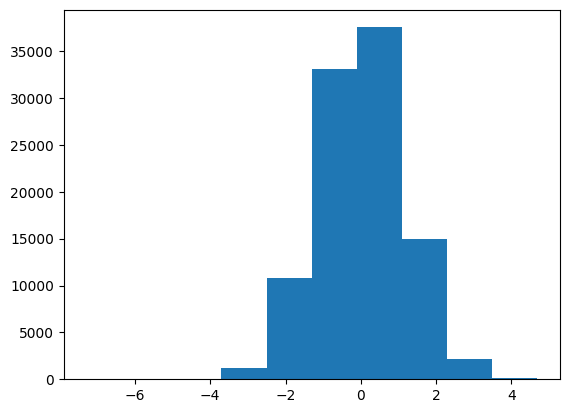

In [45]:
plt.hist(arr)